In [1]:
import pandas as pd
import numpy as np 
from random import randrange
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
 
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
 
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.models import model_from_json
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import datetime
from scipy.io import loadmat
import scipy
from scipy import stats

Using TensorFlow backend.


In [2]:
#load the csv file with the train/test or holdout dataset  
    # comment out which one you don't want to run. 
    
## dfclean = pd.read_csv('/Users/abhijnannath/gap_filled_rawtrainset_6and7covfertappanddayssince.csv')
dfclean = pd.read_csv('/n2o_nn/gap_filled_rawtrainset_6and7covfertappanddayssince.csv')

# change to holdout csv here and then rerun 
# dfclean = pd.read_csv('/n2o_nn/GlobalN2ODB_NN_fertN_datasets_holdout.csv')


In [24]:
#load the saved model for this training set as an hdf5 file
loaded_model=load_model('/n2o_nn/30day_7covariate_Do20_lr001_epoch500_rmsprop_new_monitorloss_n2osf7_w_not_norm.hdf5')



OSError: Unable to open file (unable to open file: name = '/n2o_nn/30day_7covariate_Do20_lr001_epoch500_rmsprop_new_monitorloss_n2osf7_w_not_norm.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
#r squared error function 
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

# we were getting errors with this code.... R2 should be 0-1, we were getting values outside this. Needs to be checked 

In [11]:
#check if and how many of WFPS cells are nan, and then exclude them 
dfclean['Treatment'].unique()
sum(dfclean['WFPS'].isna())

# CD - I need to revisit this from a timeseries stand point.. 

0

In [12]:
dfclean = dfclean[dfclean['WFPS'].notnull()]

In [13]:
#linear fill and forward fill the rain and irrigation columns, 
    # the rest have already been gap filled when the csv that is imported here at the top was created. 

dfclean.rain.fillna(dfclean['rainirrigation'], inplace=True)
 
#91 nan values still remain after replacing the nan rain values with the corresponding irrigation values 
#these are cases where both rain and irrigation have nan values for that row. Should I fill them with 0 or b fill ?

# #filling those 91 nan values with bfill method of pandas fill missing values 

dfclean.rain.fillna(method='ffill' ,inplace = True)
dfclean['rainirrigation'].fillna(method='ffill' ,inplace = True)
 
dfclean['rainirrigation'].fillna(method='bfill' ,inplace = True)
dfclean['soiltemp10'].fillna(method='ffill' ,inplace = True)
dfclean['Fertilizerapplied'].fillna(method='bfill' ,inplace = True)


sum(dfclean['rain'].isna()) 

0

In [14]:
sum(dfclean['Fertilizerapplied'].isna()) #no nan in fert appllied 

0

In [15]:
sum(dfclean['DaysSinceApp'].isna()) #no nan values in day since application, okay that's great we can start estimating now

0

In [16]:
dfclean.columns
site1 = dfclean.iloc[:,1] 
treatment1 = dfclean.iloc[:,5] 
sitesnew=site1+ '~'+treatment1 
df1 = pd.DataFrame(sitesnew)
 
df1.columns = ['Sites']
df1 = pd.DataFrame(df1['Sites'].unique())


In [22]:
#create a list of sites to select from while estimating 
dfsiteslistnew = []
for sites in df1.itertuples():
    dfsiteslistnew.append(sites)
dfsiteslistnew 

[Pandas(Index=0, _1='datalibrarian.158~grass.100n'),
 Pandas(Index=1, _1='datalibrarian.158~legume.0n'),
 Pandas(Index=2, _1='datalibrarian.158~legume.70n'),
 Pandas(Index=3, _1='De_Rosa_2018~Co+CONV'),
 Pandas(Index=4, _1='De_Rosa_2018~Co+Rd'),
 Pandas(Index=5, _1='De_Rosa_2018~CONV'),
 Pandas(Index=6, _1='De_Rosa_2018~Ma+Rd'),
 Pandas(Index=7, _1='deantoni~cnt'),
 Pandas(Index=8, _1='dougherty.8~100n'),
 Pandas(Index=9, _1='dougherty.8~25n'),
 Pandas(Index=10, _1='guangdi.76.auto~NoTill_Pasture'),
 Pandas(Index=11, _1='guangdi.76.auto~NoTill_Pea'),
 Pandas(Index=12, _1='guangdi.76.auto~Till_Pea'),
 Pandas(Index=13, _1='kelly.24.27~t3'),
 Pandas(Index=14, _1='kelly.30.33~t3'),
 Pandas(Index=15, _1='kelly.38~t3'),
 Pandas(Index=16, _1='kelly.52~t3'),
 Pandas(Index=17, _1='kelly.24.27~t4'),
 Pandas(Index=18, _1='kelly.30.33~t4'),
 Pandas(Index=19, _1='kelly.38~t4'),
 Pandas(Index=20, _1='kelly.52~t4'),
 Pandas(Index=21, _1='kelly.24.27~t5'),
 Pandas(Index=22, _1='kelly.24.27~t6'),
 Pand

In [17]:
#importing mu and sigma for the 7 covariate model which includes soil temp10+fertapplied and days since application 
#these values that are parameters extracted from the train set will be used to standardize our input data for the respective covariates. 
#these arrays have 7 values each 
sigma = loadmat('/n2o_nn/30day_Sigma7cov_soiltemp_fertapp_fertdayssinceapp_n2osf7.mat')
mean = loadmat('/n2o_nn/30day_Mean7cov_soiltemp_fertapp_fertdayssinceapp_n2osf7.mat')

sigma

sigmatrain =np.array(sigma['sig'])
meantrain = np.array(mean['mu'])
sigmatrain = np.squeeze(sigmatrain)
meantrain = np.squeeze(meantrain)
sigmatrain[6]

0.3726811144113354

In [18]:
#plot function 

def plot_comparison(basedf, y_true, start_idx, length=30):
  # note the 'length=30' piece. this needs to be updated if sequence length (SL) is 15 or 60. 

    save_path = '/n2o_nn'
    test_windows  = len(basedf)//30 #for 30 day sequences # again, note the changing SL value 
    # test_windows  = len(basedf)//15 # for 15 day sequences 
    basedf = basedf.values  #convert to np (normalized?) values before putting inside the for loop for prediction
     
    start_idx = 0
#     length = 30 #for ;length of day-sequences 
    length = 30 # adjusted here # 
    signal_pred = []
    signal_true = []
    for i in range(test_windows):
        end_idx = start_idx + length
        x = basedf[start_idx:end_idx]
        y_true = y_true[start_idx:end_idx]
        x = np.expand_dims(x, axis=0)
        y_pred = loaded_model.predict(x) 
        y_pred = scaler.inverse_transform(y_pred[0])
#         result = np.where(y_pred<0, 0,y_pred)
#         y_pred = scaler.inverse_transform(y_pred[0])
        signal_pred.append(y_pred)
#         signal_pred.append(scaler.inverse_transform(y_pred[0]))
#         signal_pred.append(y_pred[0])  #do not do inverse transform when using non standardised data
        signal_true.append(y_true)
        start_idx = end_idx

    signal_pred_plot  = np.asarray(signal_pred).reshape((-1,1)) 
    signal_pred_plot = signal_pred_plot[0:len(base)]  #cutting out the padded zeros for predictions before plotting 
    signal_true_plot = np.asarray(signal_true).reshape((-1,1))
    signal_true_plot.shape


#     dffinal = pd.concat([pd.DataFrame(dates),pd.DataFrame(signal_pred_plot),pd.DataFrame(y_true), pd.DataFrame(samps) ], axis=1)
    signal_pred_plot = pd.DataFrame(signal_pred_plot)
    signal_pred_plot.reset_index(drop=True, inplace=True)
    signal_true_plot = pd.DataFrame(y)
    signal_true_plot.reset_index(drop=True, inplace=True)
    dffinal = pd.DataFrame(np.hstack([signal_pred_plot,signal_true_plot, dates, samps]),columns=['Predicted', 'True', 'Dates', 'samplesgiven'])
    dffinal.Dates = pd.to_datetime(dffinal.Dates)
    
    RMSE  =  np.sqrt(((dffinal['Predicted']-dffinal['True'])**2).mean())
    NormalisedRMSE = RMSE/(dffinal['True'].max()-dffinal['True'].min())
    RollingMSE  = pd.DataFrame((dffinal['Predicted']-dffinal['True'])**2)
    Rolling_3day_MSE = np.sqrt(RollingMSE.rolling(3, min_periods=1).mean()).values
    
    Rolling_5day_MSE = np.sqrt(RollingMSE.rolling(5,min_periods=1 ).mean()).values
    Rolling_7day_MSE = np.sqrt(RollingMSE.rolling(7,min_periods=1 ).mean()).values
    Rolling_14day_MSE = np.sqrt(RollingMSE.rolling(14,min_periods=1 ).mean()).values
    Rolling_3day_MSEav = Rolling_3day_MSE.mean()
    Rolling_5day_MSEav = Rolling_5day_MSE.mean()
    Rolling_7day_MSEav = Rolling_7day_MSE.mean()
    Rolling_14day_MSEav = Rolling_14day_MSE.mean()
    Rolling_3day_MSEMedian = np.median(Rolling_3day_MSE)
    Rolling_5day_MSEMedian = np.median(Rolling_5day_MSE)
    Rolling_7day_MSEMedian = np.median(Rolling_7day_MSE)
    Rolling_14day_MSEMedian = np.median(Rolling_14day_MSE)
    Rolling_3day_MSEquantiles = pd.DataFrame(Rolling_3day_MSE).quantile([0.25,0.5,0.75]) 
     
#     e = {'Rolling_3day':Rolling_3day_MSEav, 'Rolling_5day': Rolling_5day_MSEav, 'Rolling_7day': Rolling_7day_MSEav, 'Rolling_14day':Rolling_14day_MSEav}
#     Rollingav = pd.DataFrame(data=e)
#     Rollingav = pd.DataFrame([Rolling_3day_MSEav, Rolling_5day_MSEav,Rolling_7day_MSEav, Rolling_14day_MSEav ], columns=['3dayRoll', '5dayRoll', '7dayRoll', '14dayRoll'])
    Mean_Absolute_error = (dffinal['Predicted']-dffinal['True']).abs().mean()
    NormalisedMAE = Mean_Absolute_error/(dffinal['True'].max()-dffinal['True'].min())
    R_Squared = r_squared(dffinal['True'].values, dffinal['Predicted'].values)
#     dffinal = pd.concat([signal_pred_plot,pd.DataFrame(y)], axis=1)
#     dffinal.columns = ['predictedn2o','truen2o']
     
    Rolling_MSE  = pd.DataFrame() 
     
    plt.figure(figsize=(15,8))
# #     # plt.plot(df[0], df[1:])
    plt.plot(dffinal['Dates'], dffinal['Predicted'],label='pred')
   
    plt.plot(dffinal['Dates'],dffinal['True'],label='true')
    plt.plot(dffinal['Dates'], dffinal['samplesgiven'], '*', color='green')

# # # plt.plot_date(dates, signal_true_plot,label='true')

# #         # Plot labels etc.
    plt.ylabel('N2O Emissions')
    plt.legend()
    plt.title("N2O Emmissions Predicted/True Values for"+ str(sites))
    
    fig1 = plt.gcf()
    plt.draw()
    plt.show()
    
    # to save estimation plots (this is the line actually needed to save)
    fig1.savefig('/n2o_nn/Outputclippingplots/Plot of' + str(sitename)+ '' +str(treatment) + '_n2osf7.png', dpi=100)
     
    
    plt.close()
    
    # this combines all the error metrics together.. 
    return str(sitename)+'~'+str(treatment), RMSE, NormalisedRMSE, Mean_Absolute_error,NormalisedMAE, R_Squared, Rolling_3day_MSEav,Rolling_5day_MSEav,Rolling_7day_MSEav, Rolling_14day_MSEav,  Rolling_3day_MSEMedian,  Rolling_5day_MSEMedian,  Rolling_7day_MSEMedian,  Rolling_14day_MSEMedian, Rolling_3day_MSEquantiles, dffinal



In [19]:
#inverse scaling..? 
# this part is used to inverse scale the outputs from the model.predict i.e the estimation process
matx = loadmat('/n2o_nn/30day_XTrain7cov_soiltemp_fertapp_fertdayssinceapp_n2osf7.mat')
maty = loadmat('/n2o_nn/30day_YTrain7cov_soiltemp_fertapp_fertdayssinceapp_n2osf7.mat')
matx.keys()
 
dfx = pd.DataFrame(np.hstack((matx['XTrain1'])))
# this 'XTrain1' needs to reflect what came out of matlab. Was varied from "XTrain" to "XTrain1" in some cases for the .mat files saved

dfy = pd.DataFrame(np.hstack((maty['YTrain1'])))
dfy.head

arrx = dfx.values
arry = dfy.values
resultx = arrx[:,0]
resulty = arry[:,0]
 
xlist = []
ylist  = []
for i in range(len(resultx)):
    xlist.append(np.transpose(resultx[i]))
    ylist.append(np.transpose(resulty[i]))
    
Xtrain = np.asarray(xlist)
#Update the XTrain shape values according to matlab code - would be nice to automate this! 
Xtrain = np.reshape(Xtrain, (59760, 7))
dfx = pd.DataFrame(Xtrain)

#Update the YTrain shape values according to matlab code - would be nice to automate this! 
Ytrain = np.asarray(ylist).reshape(59760,1)
dfy = pd.DataFrame(Ytrain)

dfx.columns = ['sampn2o', 'rainseq','fertilizerapplied', 'wfpsseq','dayssinceapp','soiltemp10','n2o']
df_targets = pd.DataFrame(dfy)
df_targets.columns = ['target n2o']

x_data = dfx.values
y_data = df_targets.values
num_data = len(x_data)
num_data 

scaler = StandardScaler()
print(scaler.fit(y_data))
print(scaler.mean_)
y_data =scaler.transform(y_data)
y_data.shape
     
#these values need to be updated based on the: # of segments, SL, # of rows 
x_data = x_data.reshape((1992,30,7))
y_data = y_data.reshape((1992,30,1))

x_data.shape
 

StandardScaler()
[9.98878301]


(1992, 30, 7)

In [20]:
len(xlist)

1992

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


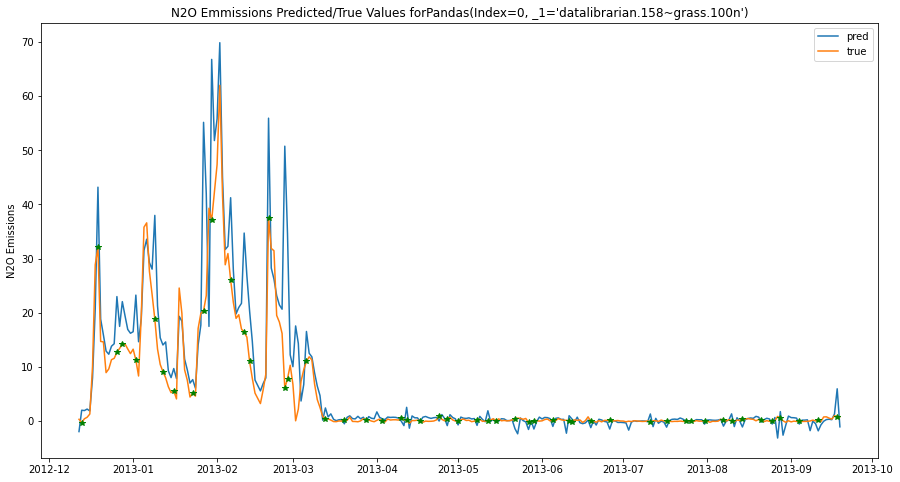

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


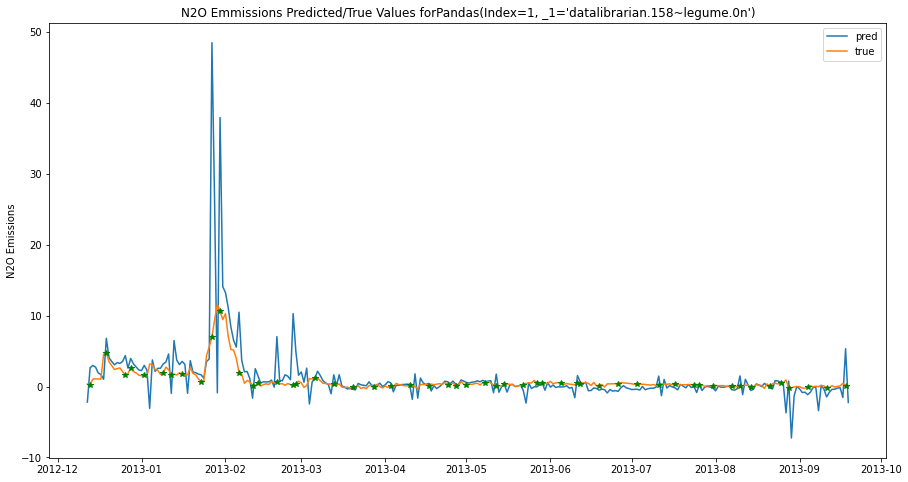

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


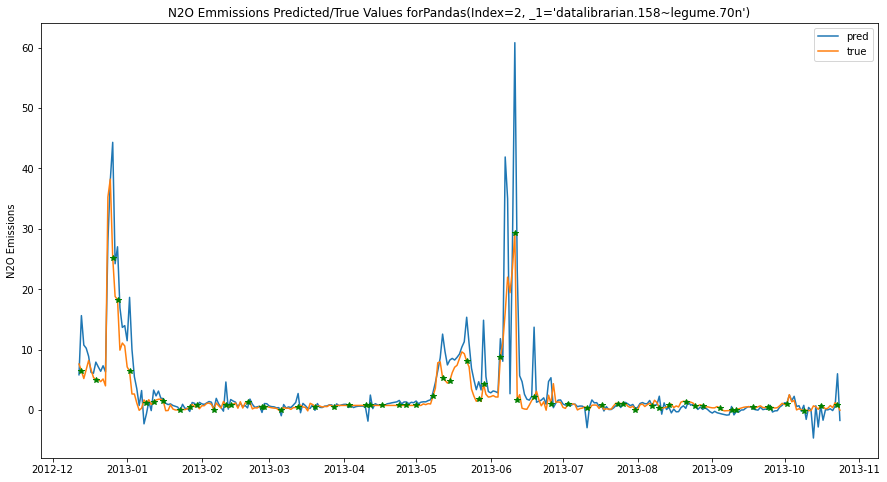

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


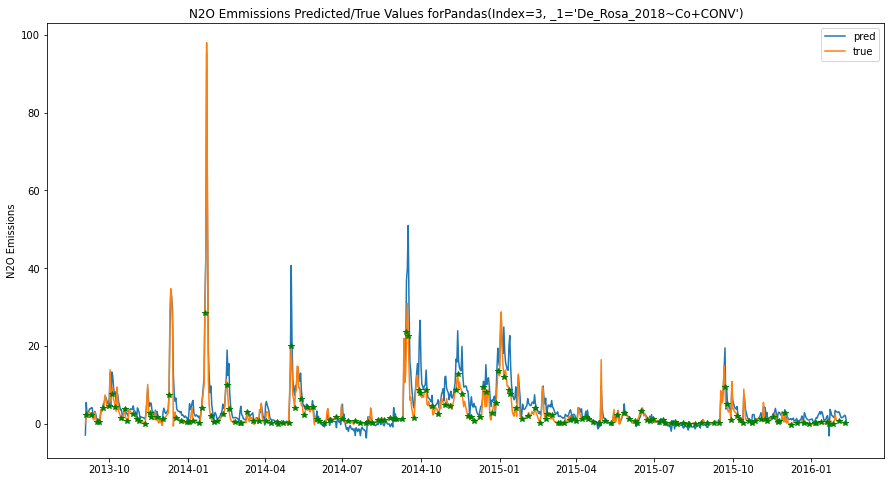

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


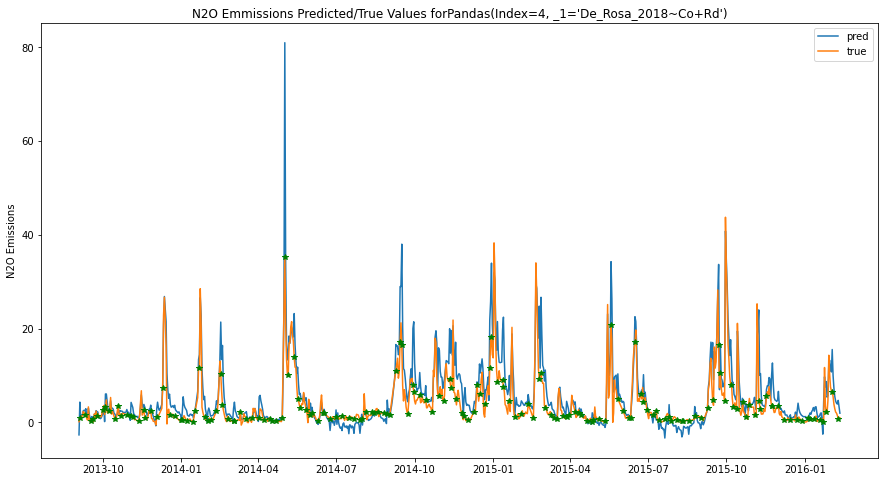

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


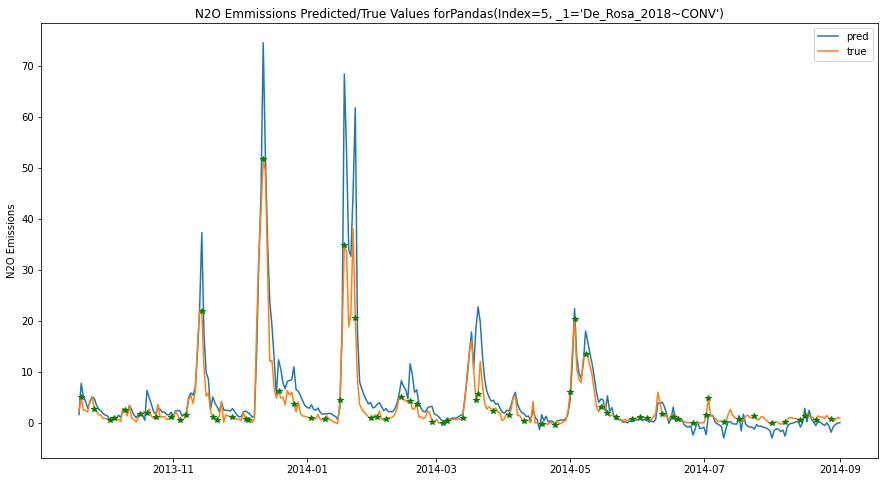

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


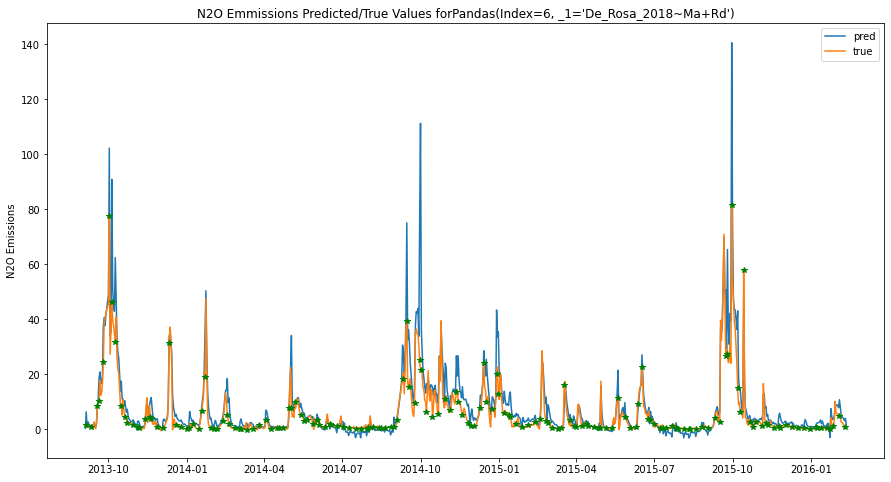

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


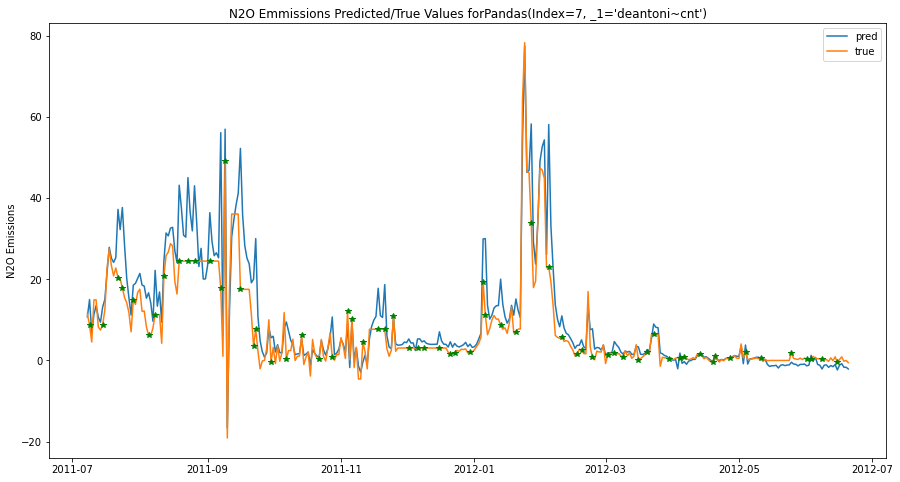

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


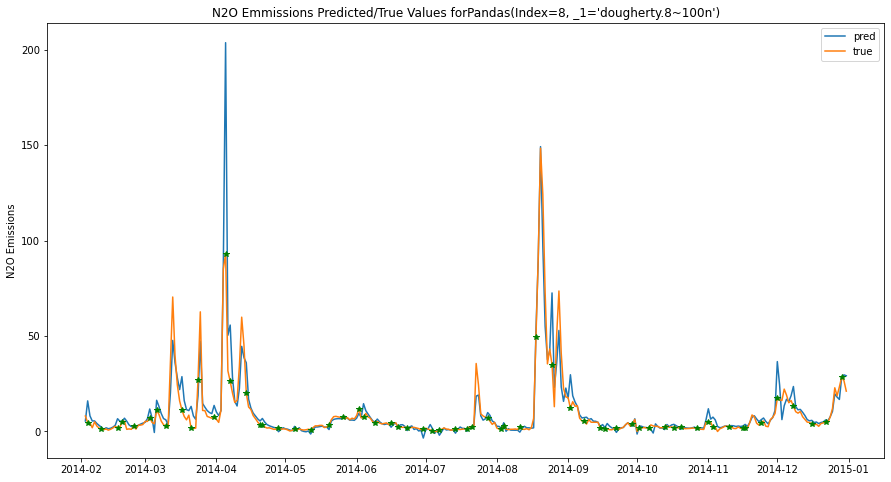

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


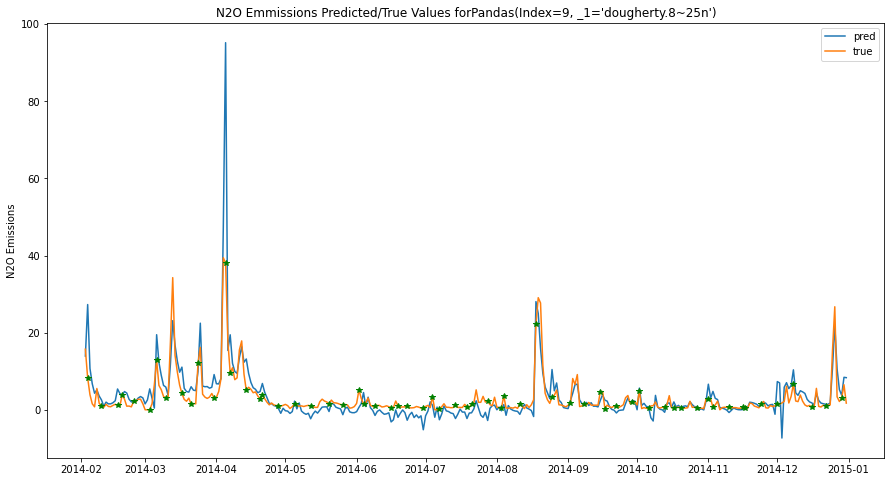

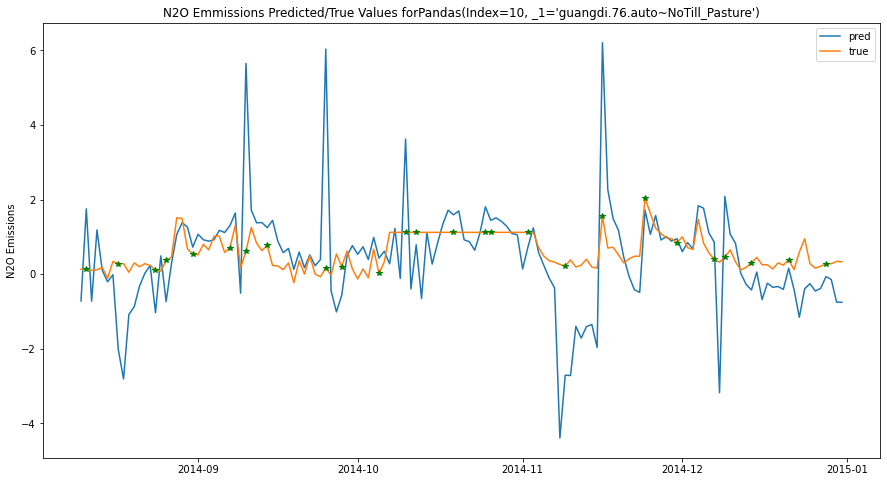

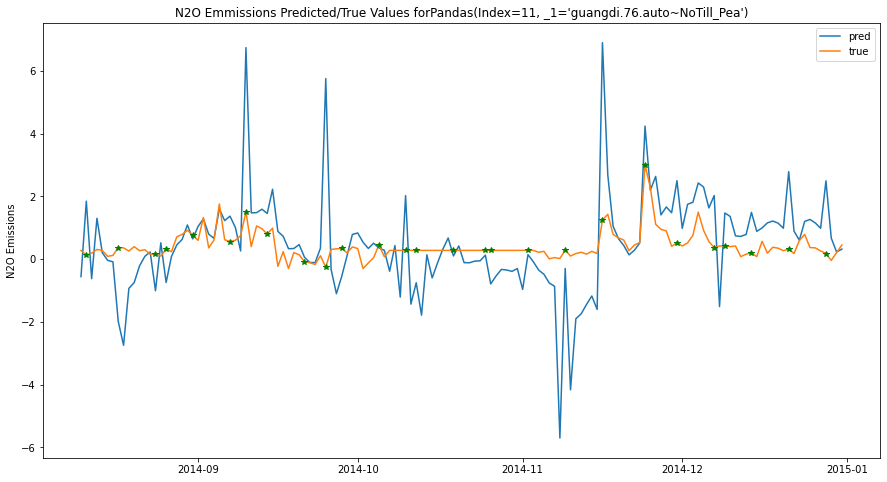

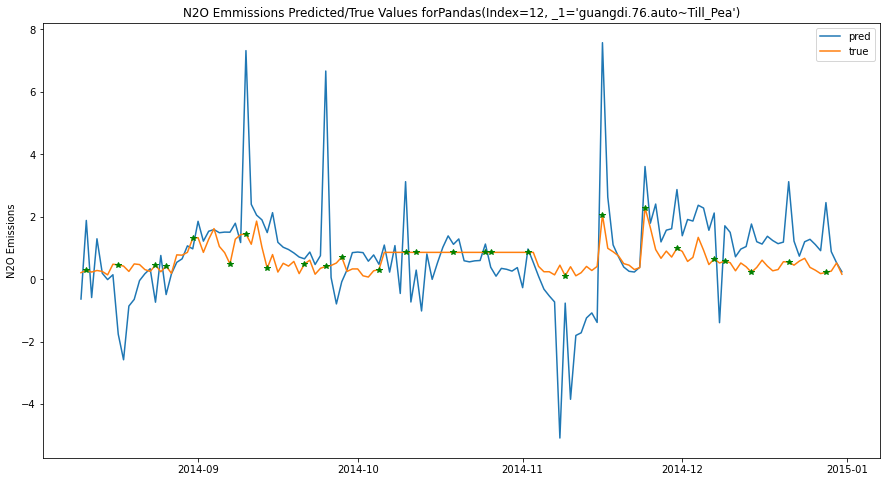

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


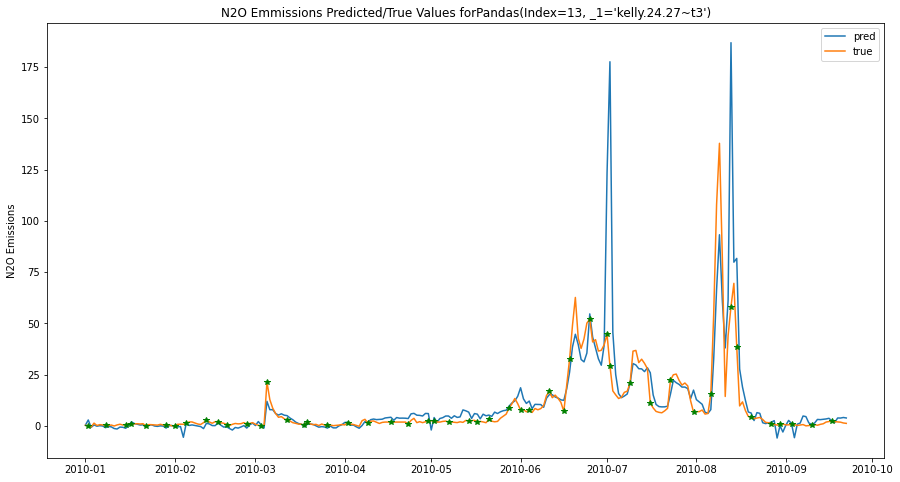

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


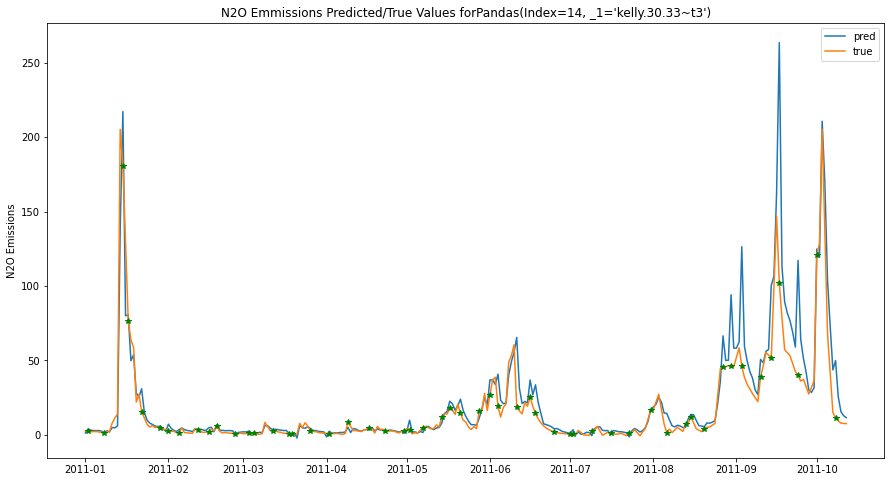

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


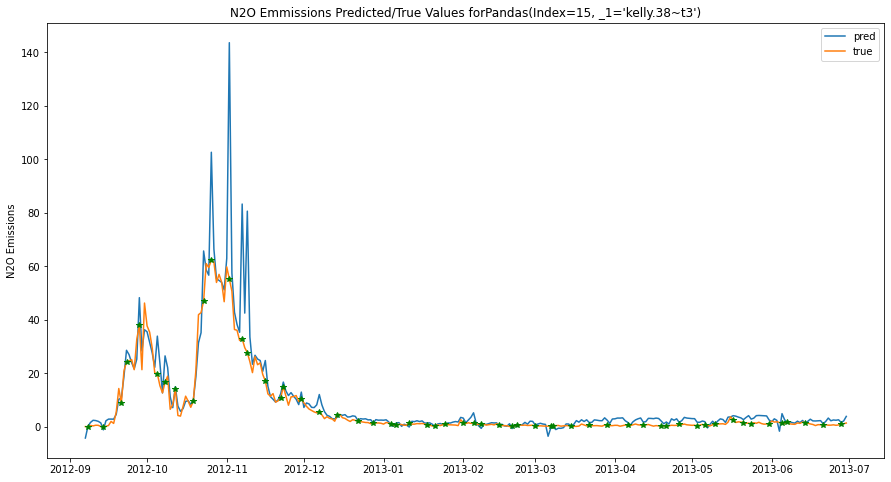

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


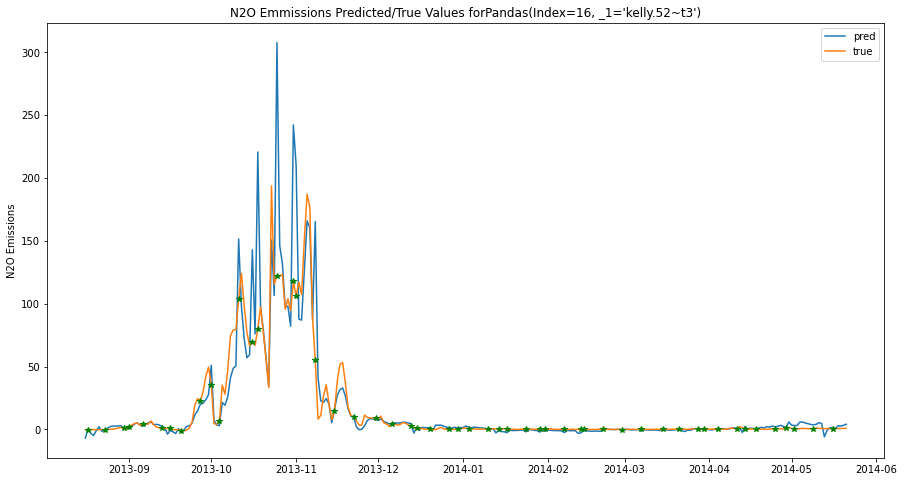

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


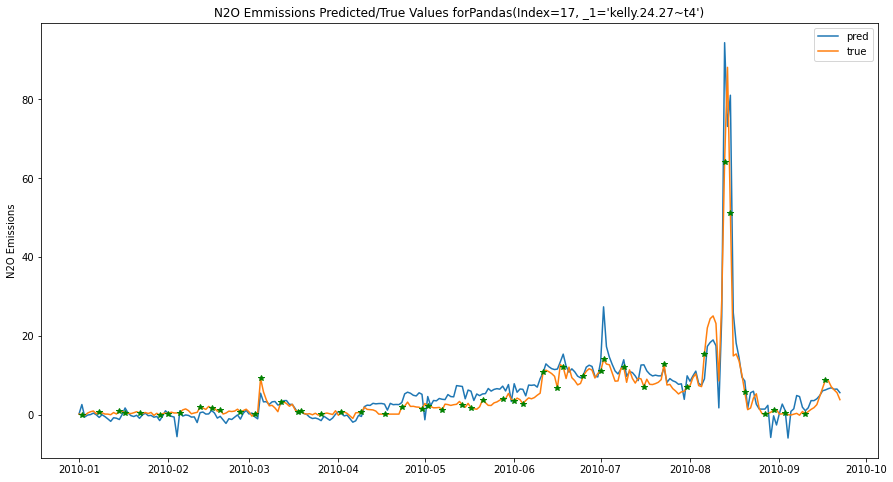

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


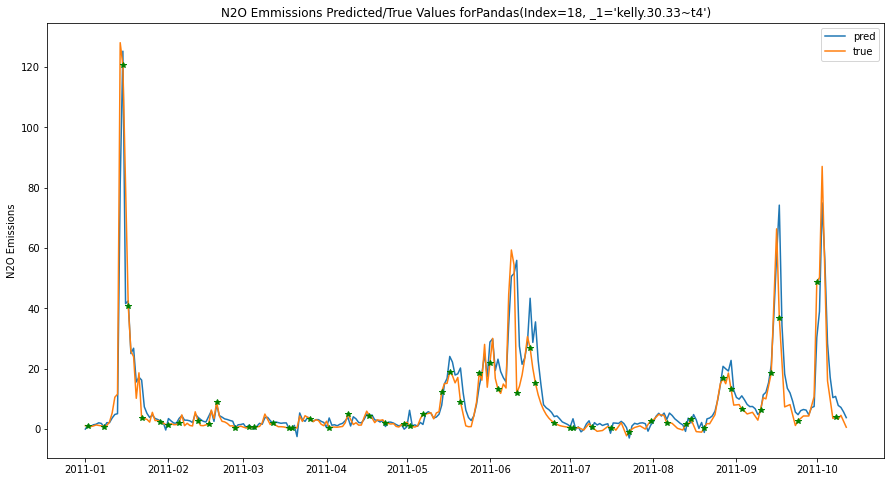

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


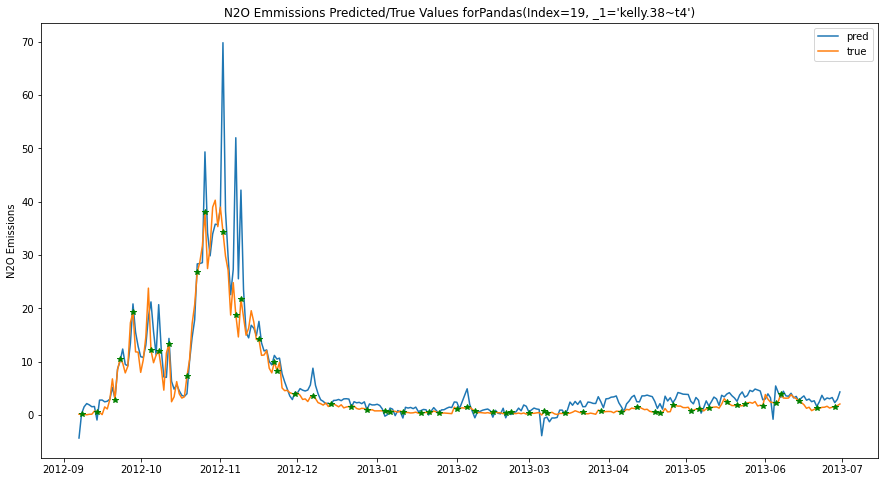

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


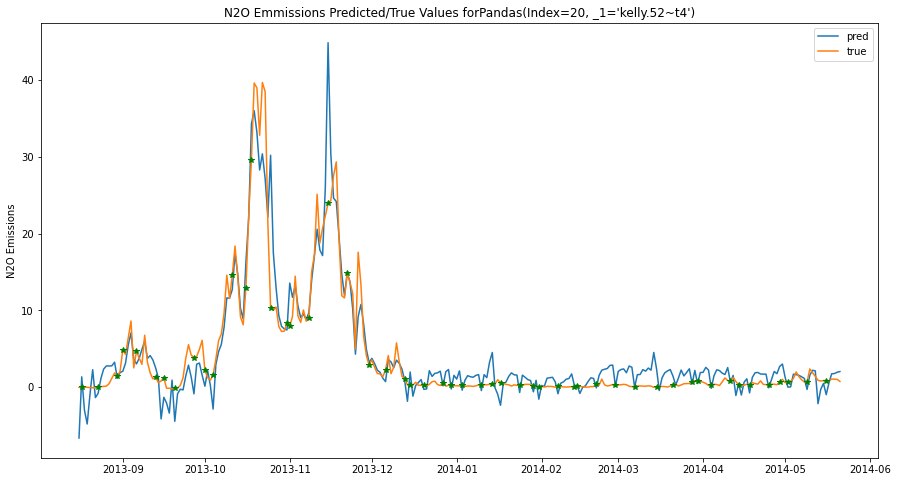

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


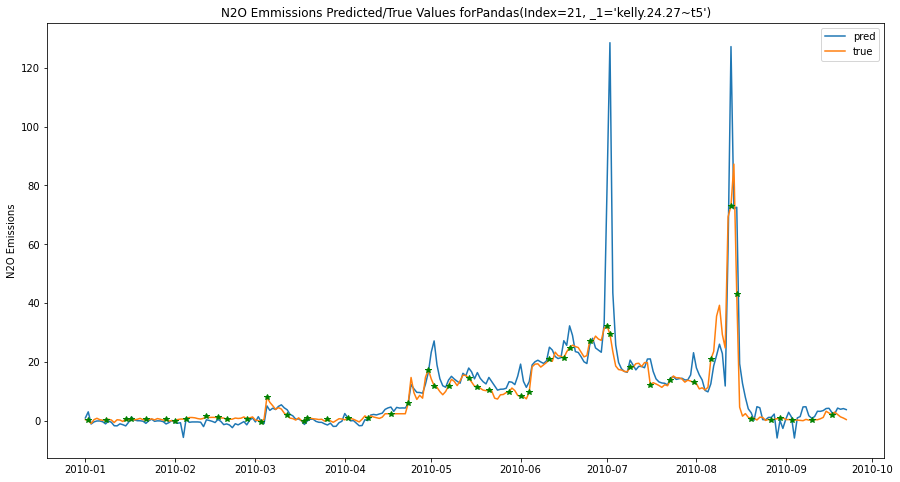

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


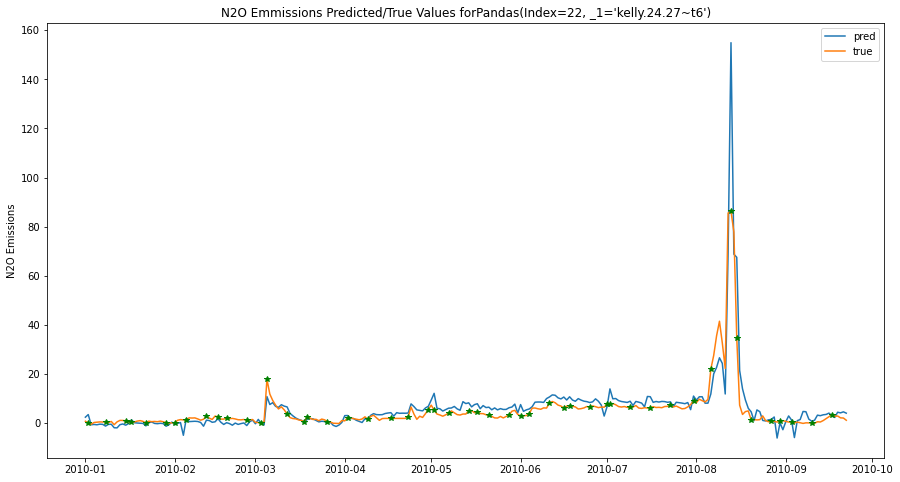

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


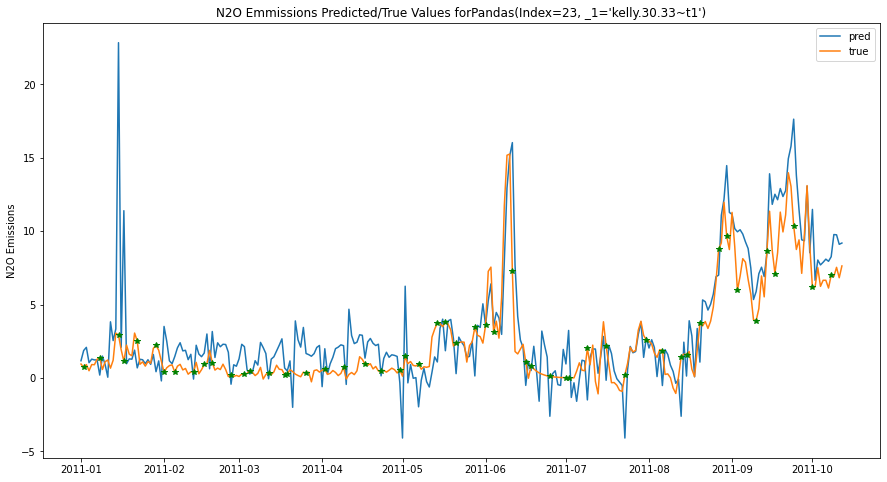

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


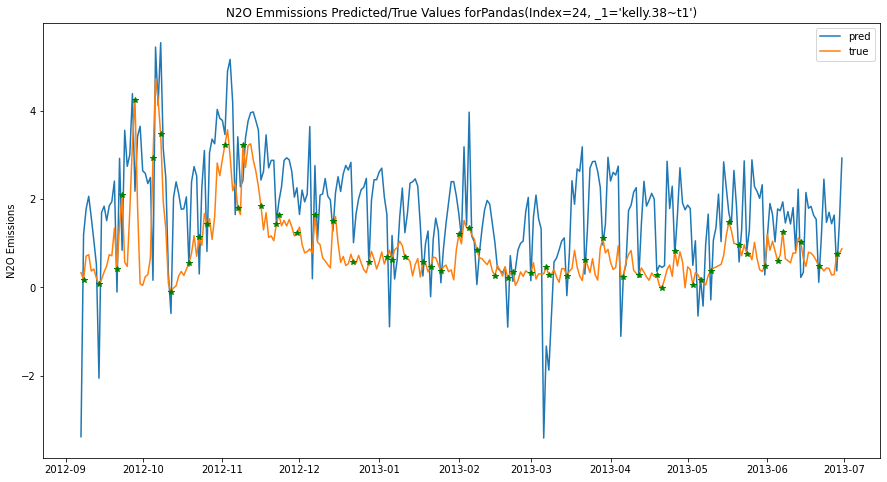

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


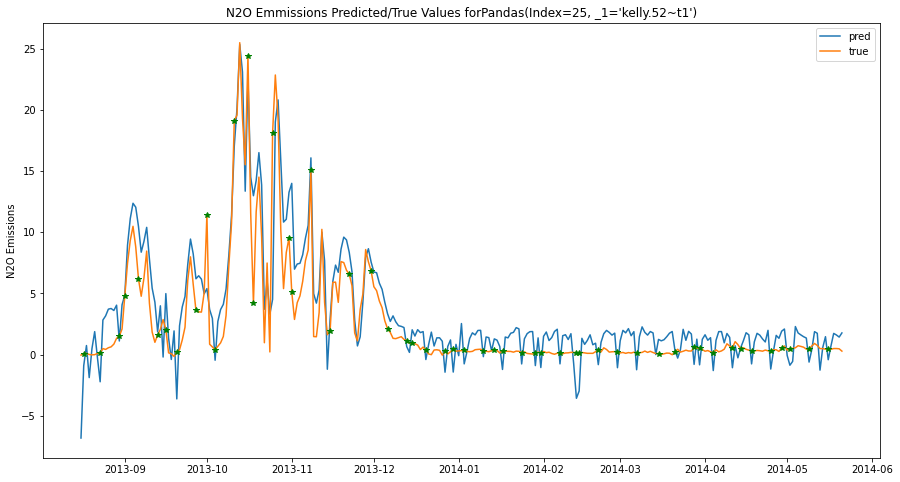

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


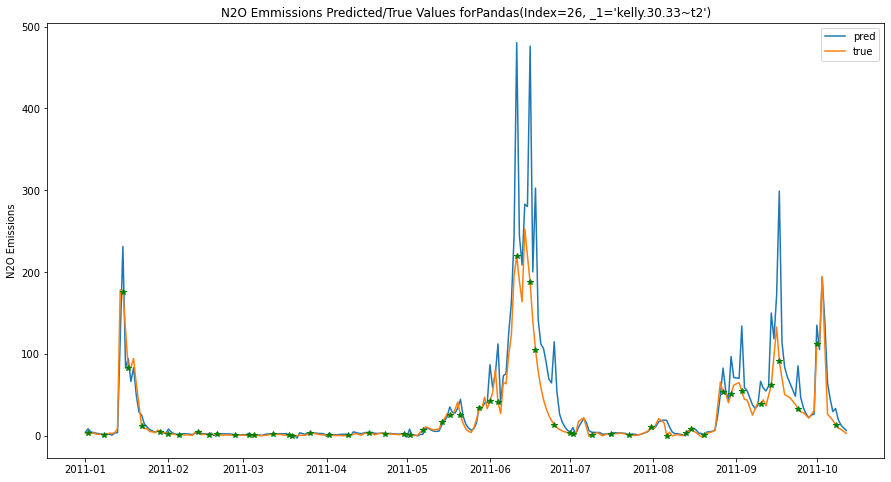

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


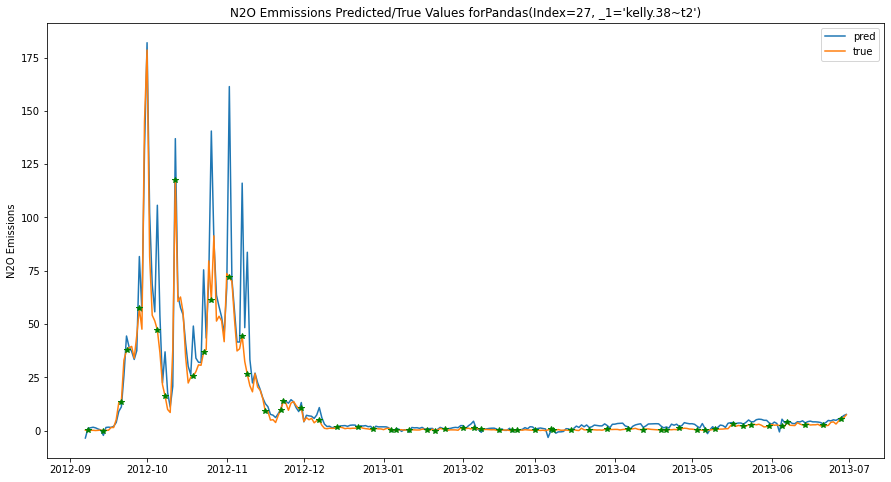

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


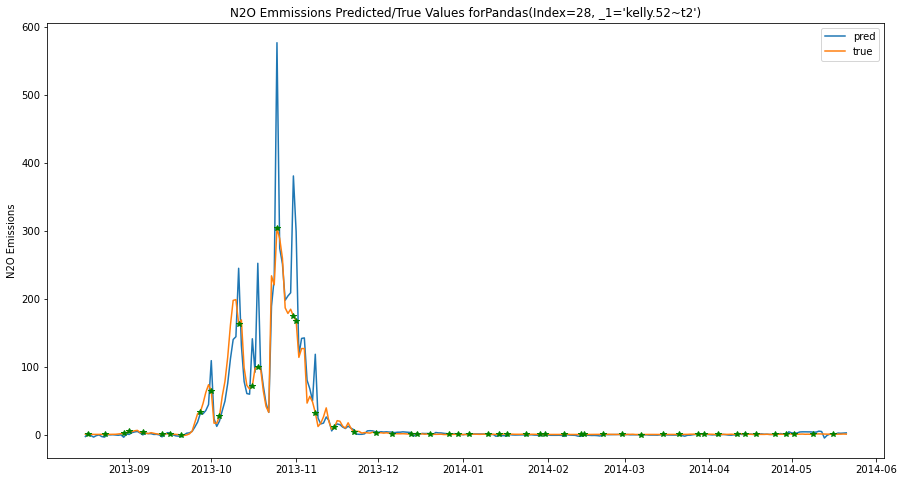

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


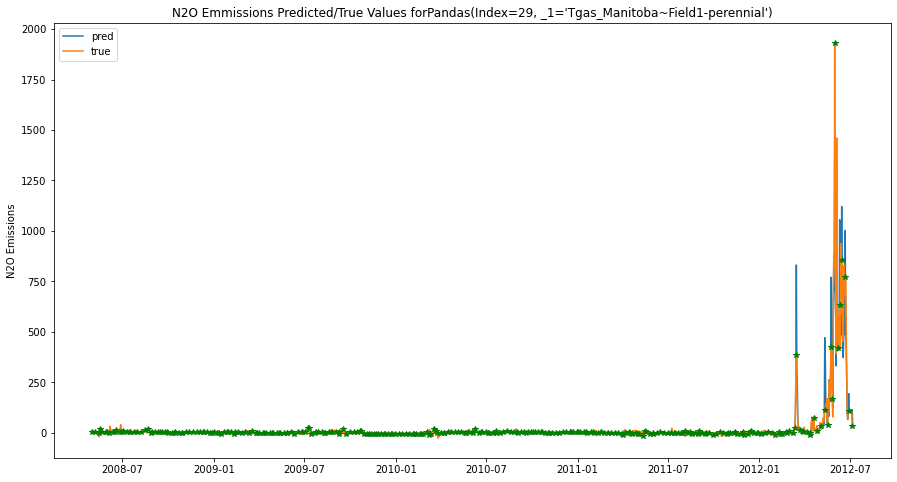

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


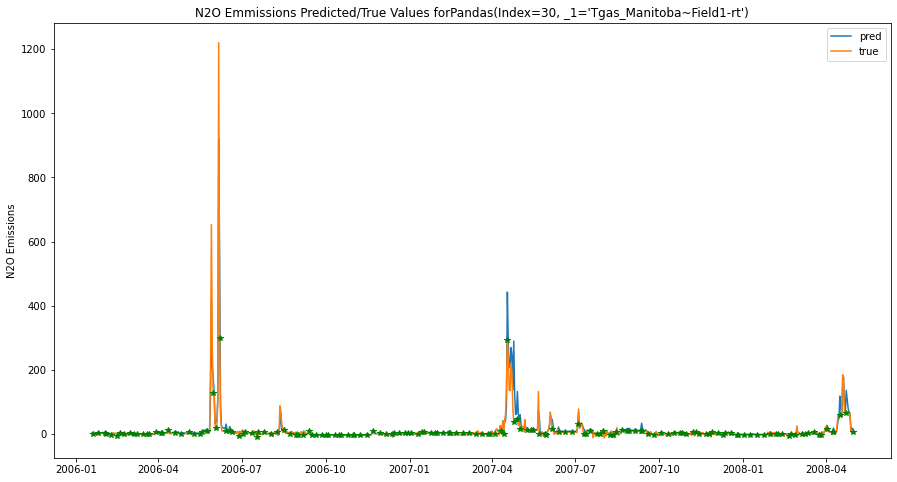

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


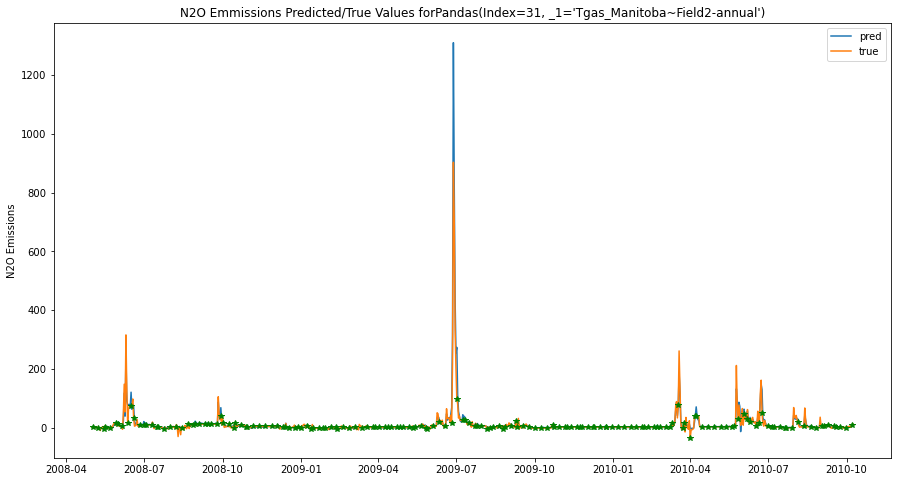

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


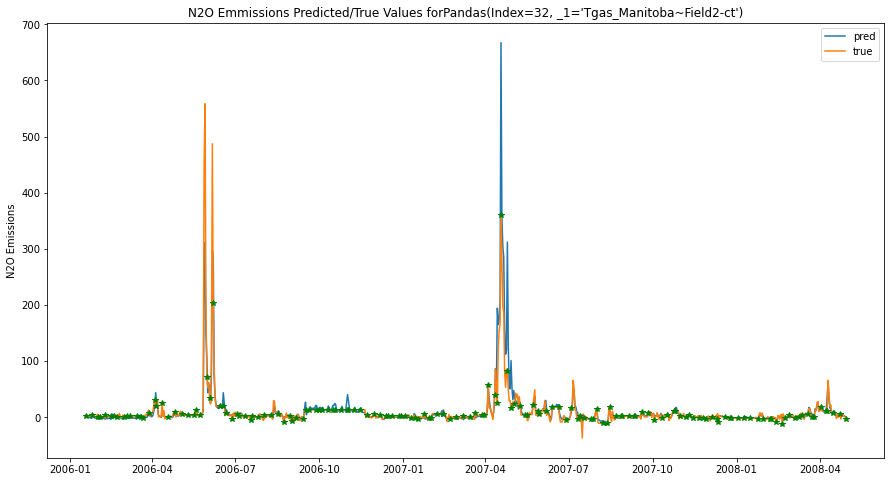

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


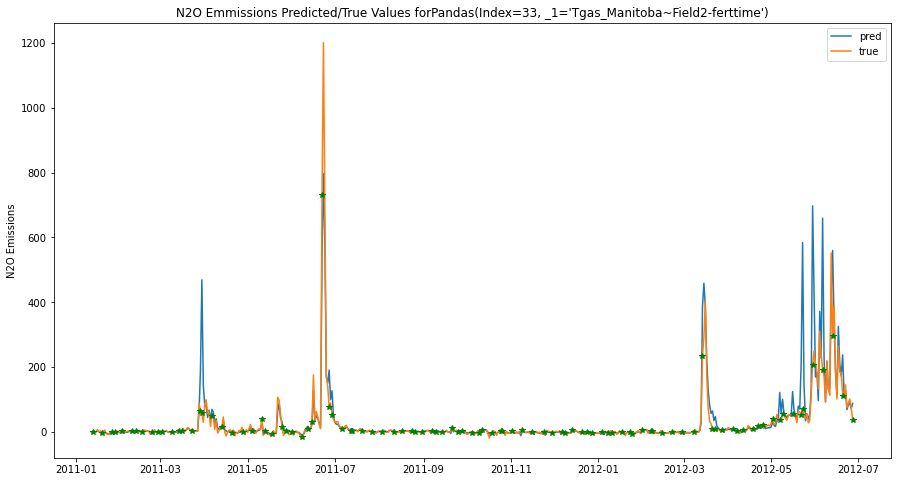

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


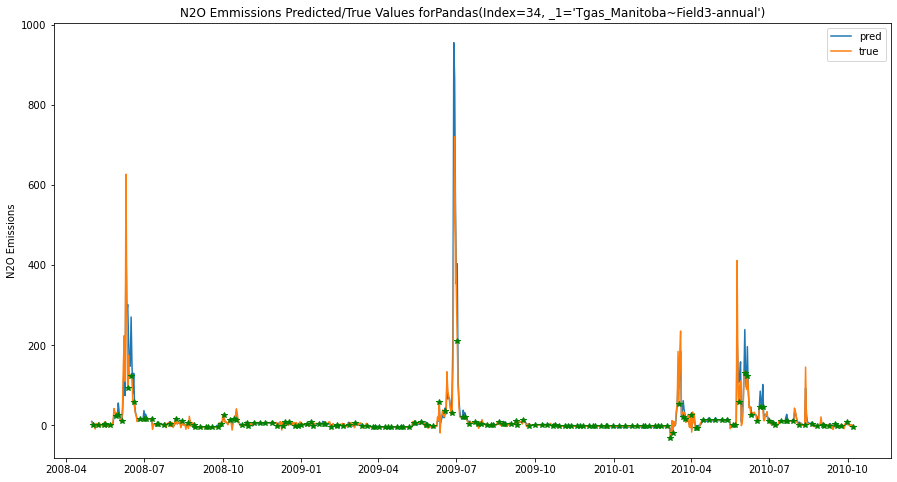

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


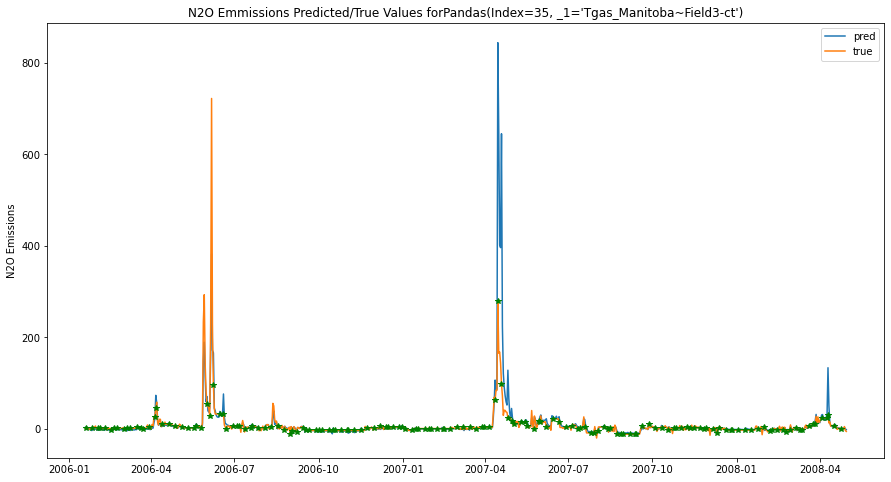

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


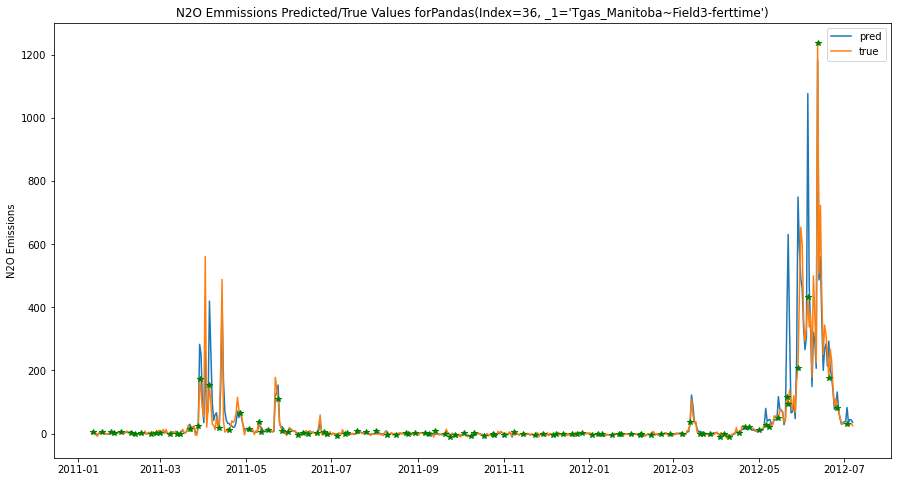

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


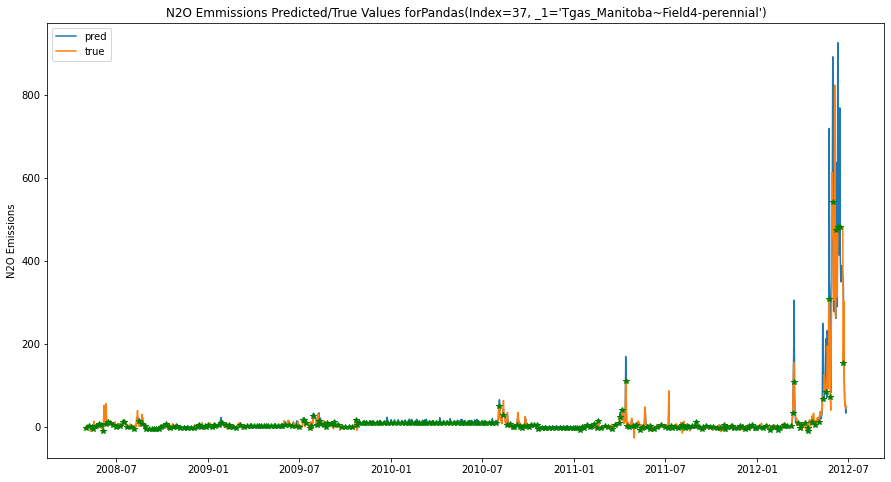

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


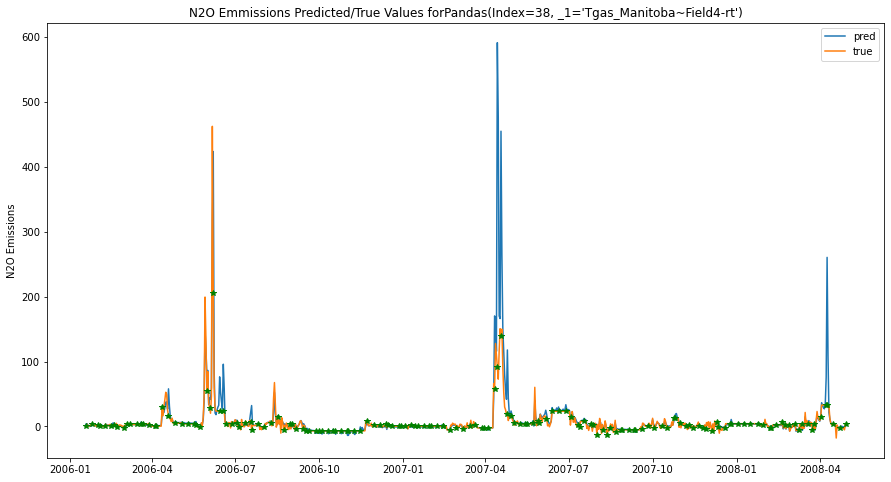

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


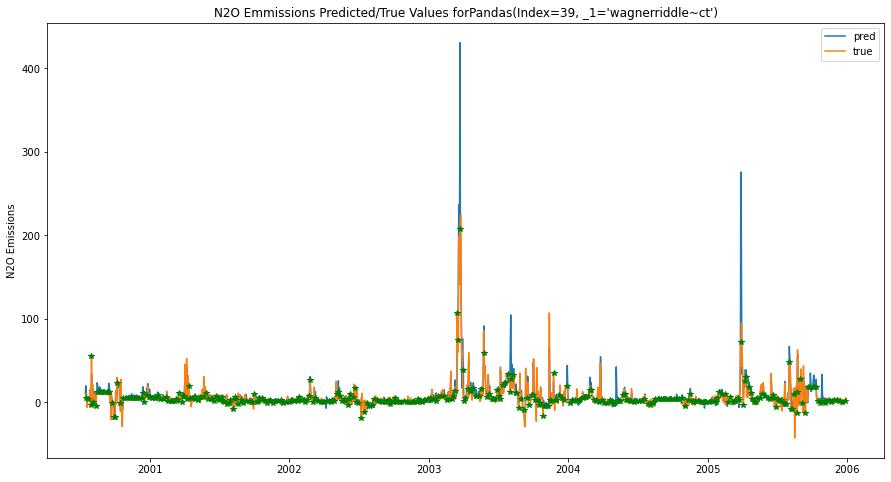

C:\Users\cddorich\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cddorich\.conda\envs\tf\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


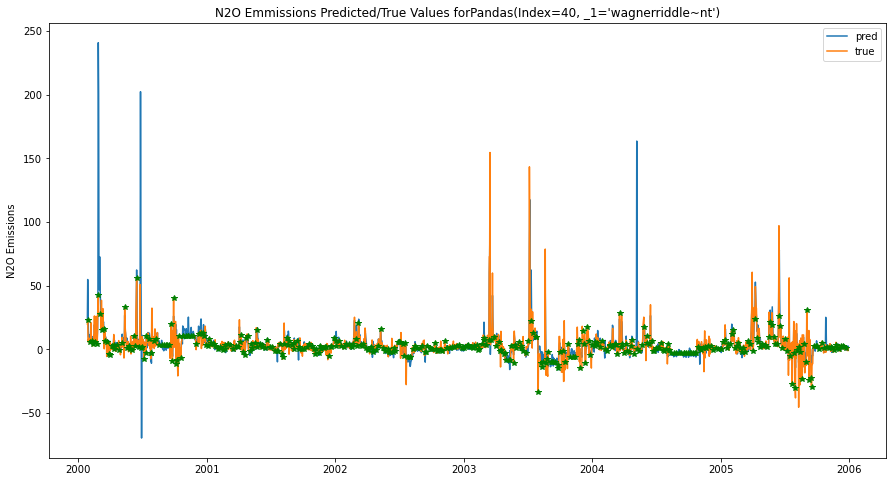

In [23]:
#this function runs the estimations for all sites and treatments and gets the plots to output

import math 
n2ocell = []
rain = []
wfpscell = []
soiltempcell = []
raincell = []
co2cell = []
ind1 = []
l = []
dailytimeseries=[]
Rolling_3day_MSE = []
Rolling_5day_MSE  = []
Rolling_7day_MSE = []
Rolling_14day_MSE = []
MeanSquaredErr = []
Rollingav = []

for sites in dfsiteslistnew :   
    sitename = sites[1].split('~')[0]
    treatment = sites[1].split('~')[1]
    data = dfclean.loc[(dfclean['SiteID'] == sitename) & (dfclean['Treatment'] ==treatment)]

    if sitename == "guangdi.76.auto":
        height, width = data.shape 
        data = data.iloc[110:height,:]
        #ind1.append(data)
      
        
#         break
    elif (sitename == "dougherty.8") & (treatment =='25N') :
        height, width = data.shape 
        data = data.iloc[110:height,:]
         
 
#     elif (sitename == "dougherty.8") & (treatment =='100N'):
#         height, width = data.shape 
#         data = data.iloc[111:height,:]
#         ind1.append(data)
#         print('here we are')
#         print(ind1)
#         break 
    
    elif sites == "dougherty.8~50N":
        height, width = data.shape 
        data = data[18:height,:]
        ind1.append(data)
        print('here we are')
          
    #get height and width of the data frame to slice out as we wish 
    height, width = data.shape 
    # pull out all the sequences from the raw data and initiate data pre-processing 
    n2oseq = data.n2o
    irrigation=data['rainirrigation'] #change the variabe/column name acc to the dataset used
#     rainplusirri = pd.concat([irrigation,irrigation])
    rain=data.rain
     
    dates = np.asarray(data.Date).reshape((-1,1))   
    
    sampidxn2oq = np.zeros(height)
    
    # check here! 
    sampidxn2oq[::7]= 1  #try giving n2o samples every 3 day # this is n2osf and not covariates, correct...? 
    ex1 = sampidxn2oq[::7]
    
    mask = sampidxn2oq ==1  #use mask to find out where sampidxn2oq values are 1
    index  = n2oseq[mask].isnull().values #finding out the null values in n2oseq where the samplidxn2oq is 1. 
    ex1[index]=0 #dimensions of the indices was smaller than the original sampidxn2oq series so we had to use another series ex1 to trim it 
    
    sampidxn2oq[::7] = ex1 # again, is this covariates or n2osf ? 
    idx = n2oseq.isnull() 
    idx1 = n2oseq.notnull() 
     
    sampidxn2oq[idx]=0   # put zeros at the indices of n2oseq where there are nan values
#     print(n2oseq[0:1].notnull())
    
    # checking out the non nan or or nan? values in each of those sites for n2oseq and replacing those indices in sampidxn2o with zero values 
    #and finding the next non nan value in n2oseq and replacing that index in sampidxn2o with 1. Using 15 day window in this process
    
    for i in range(0,height - 15,15):
        
          if(n2oseq[0:i+1].notnull().any()):
            sampidxn2oq[i]=0
            first_non_NaN_index_of_X = n2oseq[i:i+15].notnull()[0:1] 
            sampidxn2oq[i+first_non_NaN_index_of_X] = 1
            
          elif(n2oseq[i+4:i+5].notnull().any()):
            sampidxn2oq[i+4]=0
            first_non_NaN_index_of_X = n2oseq[i+4:i+15].notnull()[0:1] 
            sampidxn2oq[i+first_non_NaN_index_of_X] = 1
          elif(n2oseq[i+8:i+9].notnull().any()):
            sampidxn2oq[i+8]=0
            first_non_NaN_index_of_X = n2oseq[i+8:i+15].notnull()[0:1] 
            sampidxn2oq[i+first_non_NaN_index_of_X] = 1
          elif(n2oseq[i+12:i+13].notnull().any()):
            sampidxn2oq[i+12]=0
            first_non_NaN_index_of_X = n2oseq[i+12:i+15].notnull()[0:1] 
            sampidxn2oq[i+first_non_NaN_index_of_X] = 1
              
    k = rain
    wfpsseqq = data.WFPS  
    soilseq = data['soiltemp10'] 
    fertseq = data['Fertilizerapplied']
    dayssinceappseq = data['DaysSinceApp']
    n2oseq.interpolate(inplace = True)
    n2oseq.fillna(method='bfill', inplace = True)
    y = n2oseq   #target values used during prediction to check error. Used in the 'plot_comparison' function
     
    samps = np.asarray(n2oseq*sampidxn2oq).reshape((-1,1))
    samps[samps == 0]=np.nan
     
    # standardization here ....?
        # seems like it's late though.. 
        # need to QC that these are being applied properly - we need to look at the timeseries piece, or write it out at another spot
    n2oseq = (n2oseq - meantrain[0])/sigmatrain[0]
    rain = (rain - meantrain[1])/sigmatrain[1]
    soilseq = (soilseq -meantrain[5])/sigmatrain[5]
    
    fertseq = (fertseq -meantrain[2])/sigmatrain[2]
    dayssinceappseq = (dayssinceappseq -meantrain[4])/sigmatrain[4]
    wfpsseqq = (wfpsseqq - meantrain[3])/sigmatrain[3]
    sampidxn2oq = (sampidxn2oq - meantrain[6])/sigmatrain[6]
     
        
        
        # unsure anything happening here..
    #pad the data to make it equal in dimensions to the model prediction inputs. That is, make the number of samples
    #divisible by 60 and make sure to remove those values later after predicting and before plotting graphs     
        
    d = {'n2oseq': n2oseq,'rain': rain,'fertseq': fertseq,'wfpsseq' : wfpsseqq,'dayssinceappseq':dayssinceappseq ,'soilseq':soilseq, 'sampidxn2oq':sampidxn2oq}
    base = pd.DataFrame(data = d)  
    
    if (height%30) !=0:
        j = height // 30
        pad = pd.DataFrame(np.zeros(((j+1)*30-height, 7)))
         
        basedf = pd.DataFrame(np.vstack([base,pad]),columns=['n2oseq', 'rain','fertseq','wfpsseq','dayssinceappseq', 'soilseq', 'sampidxn2oq'])

        result = plot_comparison(basedf, y_true = y, start_idx=0, length=15)
        MeanSquaredErr.append(result[0:14])
        Rollingav.append(result[14])

        l.append(data.iloc[0:height,[0,1]]) #change the indices acc to the columns index of the dataframe(side+treatment
        dailytimeseries.append(result[15])
    
    #site level changes/mising values population/ or any other changes inside this dataframe and also try to use it to predict for each site+treatment 
#     n2oseq.interpolate(inplace = True)    #interpolated the values of n2oseq linearly where they were null 
#     n2oseq.fillna(method='bfill', inplace = True)   #some trailing nan values occurred at edges and they were filled suing backward fill
#     n2oseq = (n2oseq - meantrain[0])//sigmatrain[0]
#     rain = (rain - meantrain[1])//sigmatrain[1]
#     wfpsseq = (wfpsseq - meantrain[2])//sigmatrain[2]
#     sampidxn2oq = (sampidxn2oq - meantrain[3])//sigmatrain[3]
                
     
    ind1.append(basedf)
     
        
    #now we will have to standardize the data and divide them into batches before we can feed them into the prediction model 
    
    #now we can start predicting using out model weights 

    
    # create plots with each of those sites + treatments and save them 
    
    
    #create tables for rmse/mse values for each of those 
    
    
# appended_data = pd.concat(ind1)
 
# appended_data



#     l.append(rain.isnull().any())
#     l.append(np.where(np.isnan(irrigation))[0])
#     k[np.where(np.isnan(irrigation))[0]]  = rain[np.where(np.isnan(irrigation))[0]] # not really using rain irrigation as of now 
#     k[np.where(np.isnan(rain))[0]] = rainplusirri[np.where(np.isnan(rain))[0]]
#     b[np.where(np.isnan(b))[0]]  = a[np.where(np.isnan(b))[0]]
 

    
#     % k = nan*ones(size(rain)); % creates cell of all NaN
#     k(isnan(irrigation)) = rain(isnan(irrigation)); % in locations where rainirrigation is NaN, use rain value
#     k(isnan(rain)) = irrigation(isnan(rain));

    
#     n2ocell.append(data.n2o)
#     wfpscell.append(data.WFPS)
#     rain  = data.rain 
#     irrigation = data.rainirrigation 
#     rain[rain.isnull()]=irrigation[rain.isnull()]
#     raincell.append(rain)



In [17]:
#look at the timeseries data 
    # write the data to csv 
    
    # need to compare these predicted-true values to what is in the actual data csv file 
    
    # also, its showing SiteID and not SiteID~Treatment, so hard to line up against treatments - needs some QC here - 
appended_data = pd.DataFrame(pd.concat(dailytimeseries))
appended_data.reset_index(inplace=True, drop=True)
appended_data_sites = pd.DataFrame(pd.concat(l))
appended_data_sites.reset_index(inplace=True, drop=True)

result = pd.concat([appended_data_sites, appended_data], axis=1)
# column_names = ["Site", "Treatment", "Dates", "True","Predicted", "samplesgiven" ]
# result = result.reindex(columns=column_names)
sum(result['Predicted'].isnull())

result.to_csv('/n2o_nn/Outputclippingplots/30day_7cov_DO20_SL30_n2osf7.csv')


In [18]:
#put together the error table and write it to csv  
appended_data = pd.concat(ind1)
 
Error_Table = pd.DataFrame(MeanSquaredErr, columns=['Site+Treatment', 'RMSE','NormalisedRMSE', 'Mean_Abs_Error', 'NormalisedMAE','Rsquared','3dayRollav','5dayRollav', '7dayRollav','14dayRollav', ' Rolling_3day_MSEMedian', ' Rolling_5day_MSEMedian', ' Rolling_7day_MSEMedian',' Rolling_14day_MSEMedian'])
Error_Table.to_csv('/n2o_nn/errortable_30day_7cov_DO20_SL30_n2osf7.csv')

Error_Table

# need to revisit the R2, should be between 0-1 

,Site+Treatment,RMSE,NormalisedRMSE,Mean_Abs_Error,NormalisedMAE,Rsquared,3dayRollav,5dayRollav,7dayRollav,14dayRollav,Rolling_3day_MSEMedian,Rolling_5day_MSEMedian,Rolling_7day_MSEMedian,Rolling_14day_MSEMedian
0,datalibrarian.158~grass.100n,5.734809,0.091904,2.472328,0.039621,0.665906,2.885031,3.087874,3.217072,3.484120,0.854477,0.840525,0.849417,0.918489
1,datalibrarian.158~legume.0n,3.568638,0.299382,1.266973,0.106290,-3.513945,1.524504,1.650902,1.746910,1.951332,0.686890,0.745528,0.858759,0.882163
2,datalibrarian.158~legume.70n,3.701712,0.096499,1.526663,0.039798,0.388822,1.790312,1.928777,2.031214,2.227626,0.600309,0.619466,0.715493,0.865371
3,De_Rosa_2018~Co+CONV,2.912197,0.029577,1.780525,0.018083,0.737651,1.957120,2.045367,2.107456,2.244465,1.351275,1.439526,1.483263,1.662191
4,De_Rosa_2018~Co+Rd,3.702297,0.083455,2.207478,0.049759,0.545409,2.456278,2.580856,2.673803,2.868747,1.590452,1.714878,1.756927,1.914943
5,De_Rosa_2018~CONV,4.308229,0.082729,2.079078,0.039923,0.599671,2.351755,2.489505,2.586097,2.866359,1.343898,1.473610,1.524508,1.685216
6,De_Rosa_2018~Ma+Rd,6.260818,0.076335,2.895006,0.035297,0.609366,3.315890,3.516391,3.656964,3.979554,1.825648,1.934556,1.984420,2.032484
7,deantoni~cnt,6.036606,0.061933,3.363412,0.034507,0.708671,3.854616,4.119422,4.287965,4.555928,1.868660,1.963883,2.170111,2.952698
8,dougherty.8~100n,8.152343,0.054948,3.040486,0.020493,0.768993,3.722092,4.039599,4.260040,4.818871,1.411012,1.538530,1.742372,2.098684
9,dougherty.8~25n,4.226512,0.107196,2.095621,0.053151,0.335535,2.428336,2.615803,2.742612,3.036482,1.718042,1.839048,1.891069,1.983407
